<a href="https://colab.research.google.com/github/Entspannter/CrispCerebella/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
!git clone https://github.com/Entspannter/CrispCerebella.git

fatal: destination path 'CrispCerebella' already exists and is not an empty directory.


In [90]:
pip install -q -U keras-tuner

In [91]:
import matplotlib.pyplot as plt
import pandas as pd
import os 
from google.colab import files
from pandas import read_csv
from pandas import DataFrame
import numpy as np
from numpy import mean
from numpy import std
from numpy import array
from numpy import vstack
from numpy import dstack
from numpy import unique
from scipy import stats
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
import keras_tuner
from keras_tuner import HyperModel
from tensorflow import keras
import keras_tuner
from keras.callbacks import EarlyStopping

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [92]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

In [93]:
# Import own functions and model-classes
from CrispCerebella.Code.train_functions import *
from CrispCerebella.Code.data_loading import *
from CrispCerebella.Code.architecture import *

In [ ]:
seed = 42

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(seed)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(seed)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
tf.random.set_seed(seed)

os.environ['PYTHONHASHSEED']=str(seed)

from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [94]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)
# Same labels will be reused throughout the program
LABELS = ['Walking',
          'Upstairs',
          'Downstairs',
          'Sitting',
          'Standing',
          'Laying',
          'Jogging']
# The number of steps within one time segment
TIME_PERIODS = 128
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 64

keras version  2.5.0


In [95]:
def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
 
def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

# Load data set containing all the data from csv
df = read_data('/content/CrispCerebella/WISDM_data/WISDM_ar_v1.1_raw.txt')

In [96]:
show_basic_dataframe_info(df)
df.head(20)

Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098203



,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2
5,33,Jogging,49106442306000,1.4,-2.5,-6.5
6,33,Jogging,49106542312000,-0.6,10.6,5.7
7,33,Jogging,49106652389000,-0.5,13.9,7.1
8,33,Jogging,49106762313000,-8.4,11.4,5.1
9,33,Jogging,49106872299000,1.0,1.4,1.6


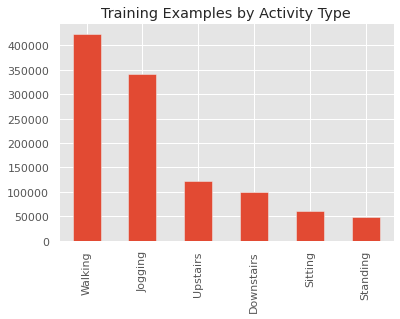

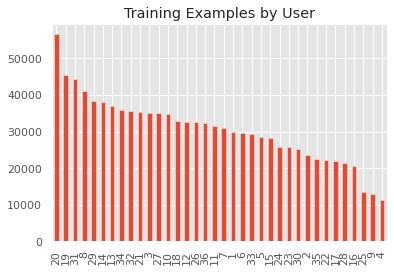

In [97]:

# Show how many training examples exist for each of the six activities
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()
# Better understand how the recordings are spread across the different
# users who participated in the study
df['user-id'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

In [98]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
#le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
#df[LABEL] = le.fit_transform(df['activity'].values.ravel())

df[LABEL] = df['activity'].apply(lambda x: LABELS.index(x))

In [99]:
# Differentiate between test set and training set
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]

In [100]:
from scipy import signal

# using a butterworth low-pass filter to extract the gravity data out of the total acc data

#sos = signal.butter(3, 0.3/(20/2), btype='low', fs=20, output='sos')
b, a  = signal.butter(3, 0.3, btype='low')
#df['x-axis_filtered'] = signal.sosfilt(sos, df['x-axis'])
#df['y-axis_filtered'] = signal.sosfilt(sos, df['y-axis'])
#df['z-axis_filtered'] = signal.sosfilt(sos, df['z-axis'])

# add the new data to our dataframe
df['x-axis_filtered'] = signal.filtfilt(b, a, df['x-axis'])
df['y-axis_filtered'] = signal.filtfilt(b, a, df['y-axis'])
df['z-axis_filtered'] = signal.filtfilt(b, a, df['z-axis'])

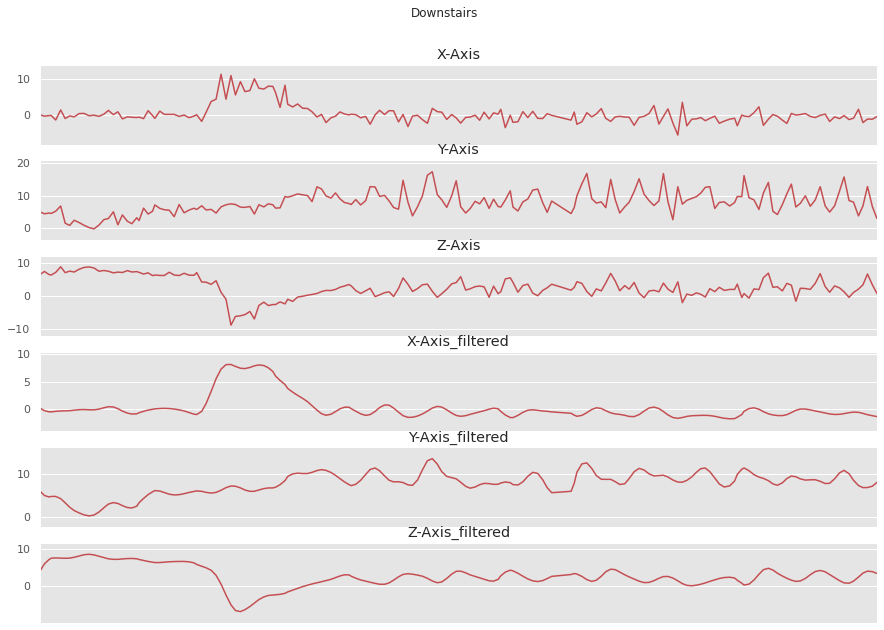

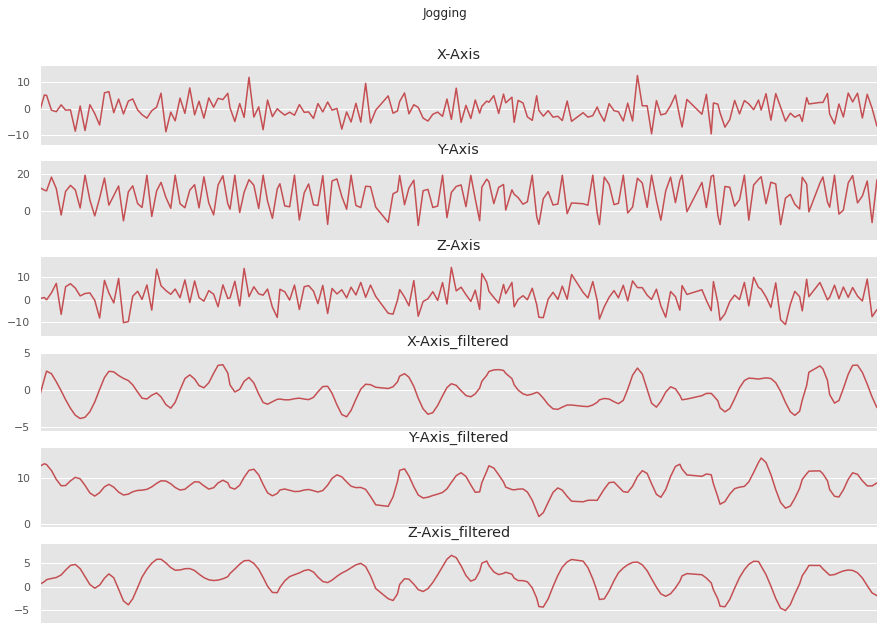

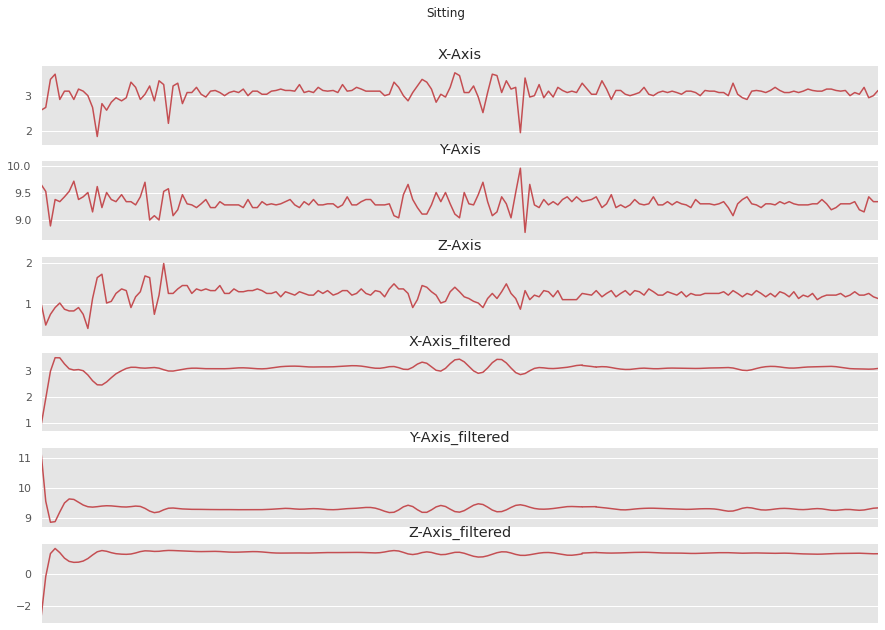

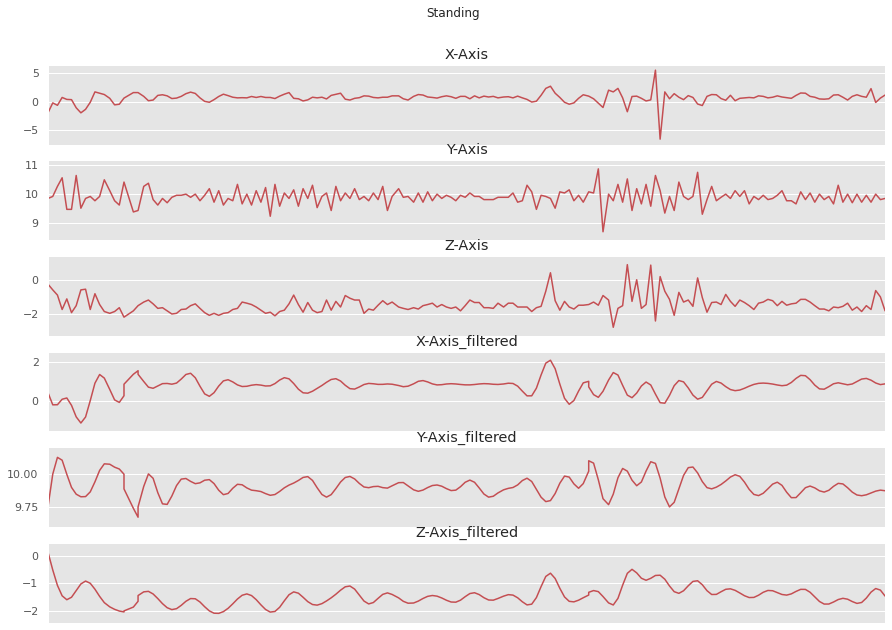

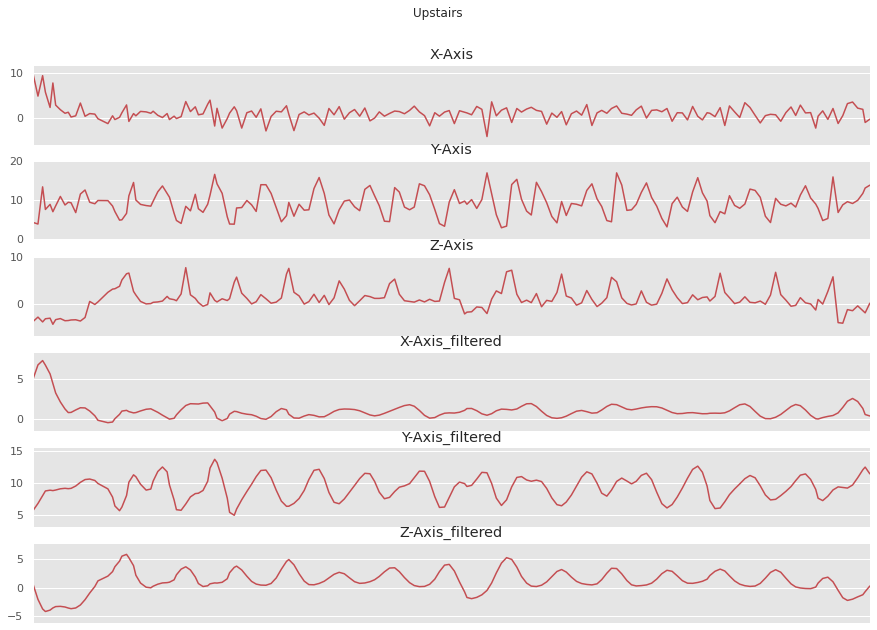

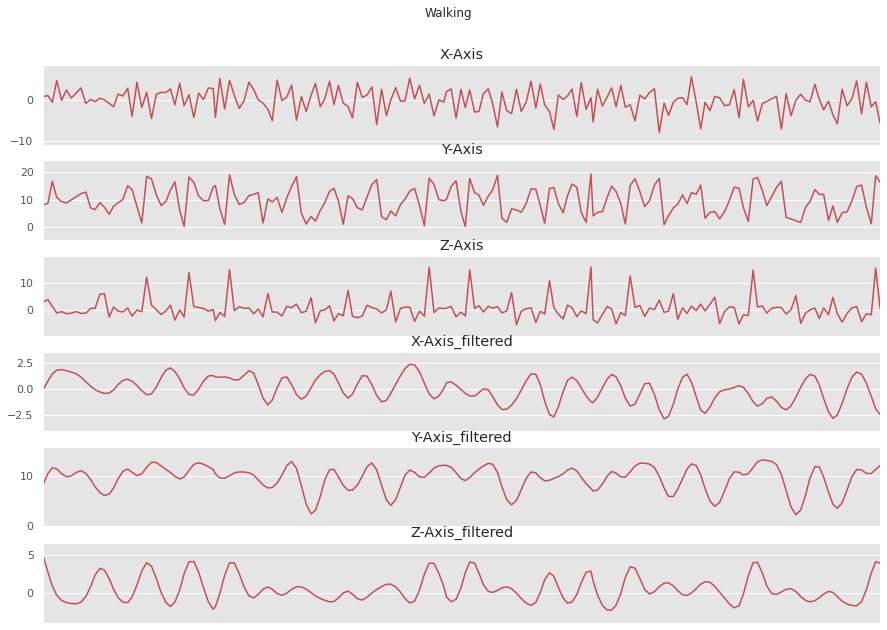

In [101]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=6,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plot_axis(ax3, data['timestamp'], data['x-axis_filtered'], 'X-Axis_filtered')
    plot_axis(ax4, data['timestamp'], data['y-axis_filtered'], 'Y-Axis_filtered')
    plot_axis(ax5, data['timestamp'], data['z-axis_filtered'], 'Z-Axis_filtered')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]
    plot_activity(activity, subset)

In [102]:
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
df['x-axis'] = df['x-axis'] / df['x-axis'].max()
df['y-axis'] = df['y-axis'] / df['y-axis'].max()
df['z-axis'] = df['z-axis'] / df['z-axis'].max()
df['x-axis_filtered'] = df['x-axis_filtered'] / df['x-axis_filtered'].max()
df['y-axis_filtered'] = df['y-axis_filtered'] / df['y-axis_filtered'].max()
df['z-axis_filtered'] = df['z-axis_filtered'] / df['z-axis_filtered'].max()
# Round numbers
df = df.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4, 'x-axis_filtered': 4, 'y-axis_filtered': 4, 'z-axis_filtered': 4})

In [103]:

def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 6
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        xs_filtered = df['x-axis_filtered'].values[i: i + time_steps]
        ys_filtered = df['y-axis_filtered'].values[i: i + time_steps]
        zs_filtered = df['z-axis_filtered'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs_filtered, ys_filtered, zs_filtered,xs, ys, zs ])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

X, y = create_segments_and_labels(df,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

In [104]:
# transform the data so that y is categorical and X and y are bith floats
X = X.astype('float32')
y = y.astype('float32')
y = np.asmatrix(y).transpose()
y = to_categorical(y)



In [105]:
X.shape

(17158, 128, 6)

In [106]:
# transform x
#X = np.dstack((X,X[:,:,:3]))
#X.shape

In [61]:
# Set input & output dimensions
num_time_periods, num_sensors = X.shape[1], X.shape[2]
#num_classes = le.classes_.size
#print(list(le.classes_))

In [62]:
#num_classes

In [107]:
# define model
verbose, epochs, batch_size = 1, 10, 64
n_timesteps, n_features, n_outputs = X.shape[1], X.shape[2], y.shape[1]
# reshape into subsequences (samples, time steps, rows, cols, channels)
n_steps, n_length = 4, 32
inputs = X
targets = y 
Model_Name_transfer = "Transfer"
inputs = inputs.reshape((inputs.shape[0], n_steps, 1, n_length, n_features))
input_shape = (n_steps, 1, n_length, n_features)


In [108]:
X.shape

(17158, 128, 6)

In [109]:
y.shape

(17158, 7)

In [110]:
inputs.shape

(17158, 4, 1, 32, 6)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
# create layers for the model
input_layer = keras.layers.InputLayer(input_shape = (n_steps, 1, n_length, n_features))

layer0 = keras.layers.Dense(100, activation='relu')
layer1 = keras.layers.ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu')
layer1.return_sequences = True
layer2 = keras.layers.Dropout(0.35)
layer3 = keras.layers.Flatten()
layer4 = keras.layers.Dense(64, activation='relu')
layer5 = keras.layers.Dropout(0.3)


layer6 = keras.layers.Dense(64, activation='relu')
layer7 = keras.layers.Dense(n_outputs, activation='softmax')
  
# create the model ot of the defined layers
model = Sequential([input_layer, layer0, layer1, layer2, layer3, layer4, layer5,  layer6, layer7])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(X_tain, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

# evaluate the model and report the loss and accuracy
scores = model.evaluate(X_test, y_test, verbose=1)
print(f'Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')



In [112]:
# load all train
trainX, trainy = datasetloader('train', '/content/CrispCerebella/Dataset/UCI HAR Dataset/')
print("Shape of training Data:",trainX.shape, trainy.shape)
# load all test
testX, testy = datasetloader('test', '/content/CrispCerebella/Dataset/UCI HAR Dataset/')
print("Shape of test Data:",testX.shape, testy.shape)

Shape of training Data: (7352, 128, 9) (7352, 1)
Shape of test Data: (2947, 128, 9) (2947, 1)


In [113]:
#trainX, trainy, testX, testy = transform_dataset(trainX, trainy, testX, testy)

# transform the train and test data and create a subset to only use the total acc and the body acc
trainX, trainy, testX, testy = transform_dataset(trainX[:,:,[0,1,2,6,7,8]], trainy, testX[:,:,[0,1,2,6,7,8]], testy)

(7352, 128, 6) (7352, 1)
(2947, 128, 6) (2947, 1)
(7352, 128, 6) (7352, 6) (2947, 128, 6) (2947, 6)


In [114]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1] 

n_steps, n_length = 4, 32

n_features

6

In [115]:
# reshape into subsequences (samples, time steps, rows, cols, channels)
trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))



In [116]:
# freeze the layers from the pretrained ConvLSTM model
layer0.trainable = False
layer1.trainable = False
layer2.trainable = False
layer3.trainable = False
layer4.trainable = False
layer5.trainable = False
layer6.trainable = False


In [117]:
layer1.return_sequences = True
epochs = 20

In [118]:
input_layer = keras.layers.InputLayer(input_shape=(n_steps, 1, n_length, n_features))
#noise_layer = keras.layers.GaussianNoise(0.05)

# create new layers to stack them on the pretrained model (to allow the model to learn from the new data)
layer0b = keras.layers.Dense(100, activation='relu')
layer1b = keras.layers.ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu')
layer2b = keras.layers.Dropout(0.3)
layer8 = keras.layers.Dense(100, activation='relu')
layer9 = keras.layers.Dense(n_outputs, activation='softmax')

# create the new model containing freezed and trainable layers
supermodel = Sequential([input_layer, layer0, layer1,  layer2,  layer0b, layer1b, layer2b, layer3, layer8 , layer9])
supermodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fitting the model
supermodel.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/20
115/115 [==============================] - 32s 233ms/step - loss: 1.3197 - accuracy: 0.4365
Epoch 2/20
115/115 [==============================] - 27s 231ms/step - loss: 0.5639 - accuracy: 0.7671
Epoch 3/20
115/115 [==============================] - 27s 231ms/step - loss: 0.4796 - accuracy: 0.8043
Epoch 4/20
115/115 [==============================] - 27s 231ms/step - loss: 0.4104 - accuracy: 0.8331
Epoch 5/20
115/115 [==============================] - 27s 231ms/step - loss: 0.3730 - accuracy: 0.8491
Epoch 6/20
115/115 [==============================] - 27s 233ms/step - loss: 0.3554 - accuracy: 0.8545
Epoch 7/20
115/115 [==============================] - 27s 231ms/step - loss: 0.3396 - accuracy: 0.8620
Epoch 8/20
115/115 [==============================] - 27s 234ms/step - loss: 0.2966 - accuracy: 0.8802
Epoch 9/20
115/115 [==============================] - 27s 232ms/step - loss: 0.2891 - accuracy: 0.8820
Epoch 10/20
115/115 [==============================] - 27s 231ms/step - l

In [119]:
# evaluationg the new model
supermodel.evaluate(testX, testy, batch_size= batch_size)

47/47 [==============================] - 5s 93ms/step - loss: 0.5551 - accuracy: 0.8198


[0.5551288723945618, 0.8198167681694031]

In [120]:
# to perform a finetuning on the given parameters the layers are set to trainable again
layer0.trainable = True
layer1.trainable = True
layer2.trainable = True
layer0b.trainable = True
layer1b.trainable = True
layer2b.trainable = True
layer8.trainable = True
layer9.trainable = True

# try the same model, but with a little ability to adjust the frozen layer wights
supermodel = Sequential([input_layer, layer0, layer1,  layer2,  layer0b, layer1b, layer2b, layer3, layer8 , layer9])
supermodel.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-5), metrics=['accuracy'])
supermodel.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
supermodel.evaluate(testX, testy, batch_size= batch_size)

Epoch 1/20
115/115 [==============================] - 48s 357ms/step - loss: 0.1738 - accuracy: 0.9255
Epoch 2/20
115/115 [==============================] - 42s 362ms/step - loss: 0.1580 - accuracy: 0.9349
Epoch 3/20
115/115 [==============================] - 41s 359ms/step - loss: 0.1590 - accuracy: 0.9332
Epoch 4/20
115/115 [==============================] - 41s 359ms/step - loss: 0.1623 - accuracy: 0.9283
Epoch 5/20
115/115 [==============================] - 41s 360ms/step - loss: 0.1467 - accuracy: 0.9372
Epoch 6/20
115/115 [==============================] - 42s 362ms/step - loss: 0.1471 - accuracy: 0.9367
Epoch 7/20
115/115 [==============================] - 41s 359ms/step - loss: 0.1473 - accuracy: 0.9381
Epoch 8/20
115/115 [==============================] - 41s 359ms/step - loss: 0.1400 - accuracy: 0.9414
Epoch 9/20
115/115 [==============================] - 41s 358ms/step - loss: 0.1395 - accuracy: 0.9382
Epoch 10/20
115/115 [==============================] - 41s 357ms/step - l

[0.5408011078834534, 0.8469629883766174]

In [121]:
file_name_ending = "8469"

In [122]:
# save the model by using the unique file name 
supermodel.save("/content/CrispCerebella/Models/Final_Model_Transfermodel_" + file_name_ending)

INFO:tensorflow:Assets written to: /content/CrispCerebella/Models/Final_Model_Transfermodel_8469/assets


INFO:tensorflow:Assets written to: /content/CrispCerebella/Models/Final_Model_Transfermodel_8469/assets


In [123]:
# create a zip file out of the saved model

!zip -r /content/CrispCerebella/Models/Final_Model_Transfermodel_{file_name_ending}.zip /content/CrispCerebella/Models/Final_Model_Transfermodel_{file_name_ending}

  adding: content/CrispCerebella/Models/Final_Model_Transfermodel_8469/ (stored 0%)
  adding: content/CrispCerebella/Models/Final_Model_Transfermodel_8469/variables/ (stored 0%)
  adding: content/CrispCerebella/Models/Final_Model_Transfermodel_8469/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: content/CrispCerebella/Models/Final_Model_Transfermodel_8469/variables/variables.index (deflated 68%)
  adding: content/CrispCerebella/Models/Final_Model_Transfermodel_8469/saved_model.pb (deflated 90%)
  adding: content/CrispCerebella/Models/Final_Model_Transfermodel_8469/assets/ (stored 0%)
  adding: content/CrispCerebella/Models/Final_Model_Transfermodel_8469/keras_metadata.pb (deflated 85%)


In [124]:
# downloading the zip file (to store it locally and be able to push it to git)

files.download(f"/content/CrispCerebella/Models/Final_Model_Transfermodel_{file_name_ending}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>